# Thoracic Surgery Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import scipy
import seaborn as sns
import math

from scipy.io import arff
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,ConfusionMatrixDisplay, classification_report,accuracy_score,f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

## Loading Data

In [3]:
Datset = arff.loadarff("Classification_Datasets/7_Thoracic_Surgery_Data/thoracic_surgery_data.arff") 


In [4]:
df = pd.DataFrame(Datset[0])
df.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
0,b'DGN2',2.88,2.16,b'PRZ1',b'F',b'F',b'F',b'T',b'T',b'OC14',b'F',b'F',b'F',b'T',b'F',60.0,b'F'
1,b'DGN3',3.40,1.88,b'PRZ0',b'F',b'F',b'F',b'F',b'F',b'OC12',b'F',b'F',b'F',b'T',b'F',51.0,b'F'
2,b'DGN3',2.76,2.08,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC11',b'F',b'F',b'F',b'T',b'F',59.0,b'F'
3,b'DGN3',3.68,3.04,b'PRZ0',b'F',b'F',b'F',b'F',b'F',b'OC11',b'F',b'F',b'F',b'F',b'F',54.0,b'F'
4,b'DGN3',2.44,0.96,b'PRZ2',b'F',b'T',b'F',b'T',b'T',b'OC11',b'F',b'F',b'F',b'T',b'F',73.0,b'T'


## Data preparation and Analysis

In [5]:
print(np.count_nonzero(Datset==np.nan))

0


In [6]:
frequency = df['Risk1Yr'].value_counts()
print(frequency)
print("-------")

b'F'    400
b'T'     70
Name: Risk1Yr, dtype: int64
-------


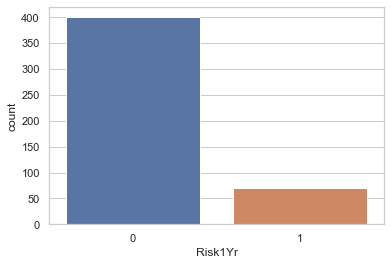

In [101]:
sns.countplot(x='Risk1Yr', data= df);

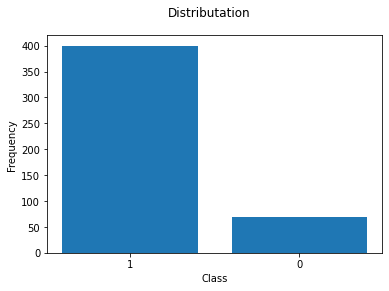

In [7]:
plt.plot()
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.bar( ("1","0"), frequency)
plt.suptitle("Distributation")
plt.show()

In [8]:
df.dtypes

DGN         object
PRE4       float64
PRE5       float64
PRE6        object
PRE7        object
PRE8        object
PRE9        object
PRE10       object
PRE11       object
PRE14       object
PRE17       object
PRE19       object
PRE25       object
PRE30       object
PRE32       object
AGE        float64
Risk1Yr     object
dtype: object

ok


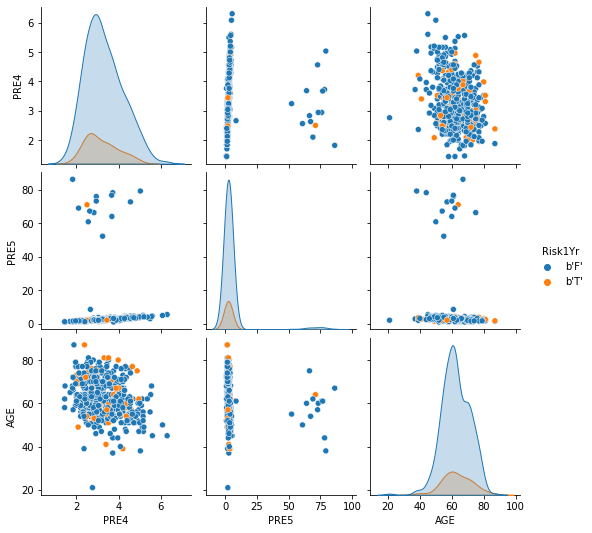

In [9]:
sns.pairplot(df, hue="Risk1Yr")
print("ok")

<AxesSubplot:>

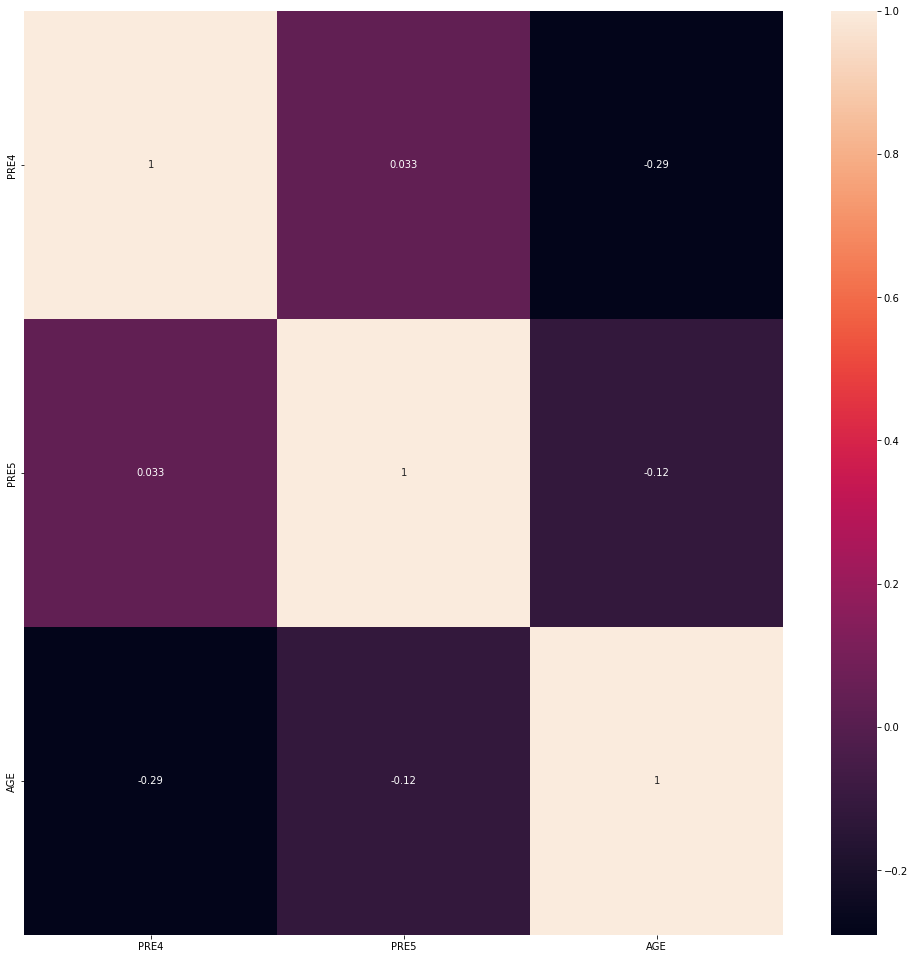

In [10]:
plt.figure(figsize=(17,17))
sns.heatmap(df.corr(), annot =True)

In [11]:
for column in df:
    if df[column].dtypes != np.float64:
        # if data in column is type string, we want to convert it to equivalent numerical labels
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(df[column])
        df[column] = integer_encoded

In [12]:
# .astype(int)
df.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
0,1,2.88,2.16,1,0,0,0,1,1,3,0,0,0,1,0,60.0,0
1,2,3.40,1.88,0,0,0,0,0,0,1,0,0,0,1,0,51.0,0
2,2,2.76,2.08,1,0,0,0,1,0,0,0,0,0,1,0,59.0,0
3,2,3.68,3.04,0,0,0,0,0,0,0,0,0,0,0,0,54.0,0
4,2,2.44,0.96,2,0,1,0,1,1,0,0,0,0,1,0,73.0,1


In [13]:
df.dtypes

DGN          int64
PRE4       float64
PRE5       float64
PRE6         int64
PRE7         int64
PRE8         int64
PRE9         int64
PRE10        int64
PRE11        int64
PRE14        int64
PRE17        int64
PRE19        int64
PRE25        int64
PRE30        int64
PRE32        int64
AGE        float64
Risk1Yr      int64
dtype: object

### Defining Dictionary of Models

In [55]:
MODELS = {'logistic_r', 'svc', 'tree', 'random_forest_r', 'knn', 'adaboost', 'gnb', 'nn'}
thoracic_surgery_dict = {}    

## Train and Test set

In [15]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1:]
# y = df.Class.apply(lambda x: pd.to_numeric(str(x)[2]))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x.astype(int), y.astype(int), test_size=0.2, random_state=0)

y_train = y_train.to_numpy().reshape(-1)
y_test = y_test.to_numpy().reshape(-1)

In [17]:
StScale = StandardScaler()
X_train = StScale.fit_transform(X_train)
X_test = StScale.transform(X_test)

In [18]:
from tabulate import tabulate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def model_results(model):
    table = [["Parameters / Metrics", "Tuned"]]
    curr_model = model['model']

    if model['hyperparameters'] == 1:
        for param in curr_model.best_params_:
            table.append([param, curr_model.best_params_[param]])

    prediction = curr_model.predict(X_test)
    mse = mean_squared_error(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    print(accuracy)
    weighted_f1 = f1_score(y_test, prediction, average='weighted')
    macro_f1 = f1_score(y_test, prediction, average='macro')
    
    table.append(['Accuracy', accuracy])
    table.append(['weighted_f1', weighted_f1])
    table.append(['macro_f1',macro_f1])

    print(tabulate(table, headers='firstrow', tablefmt='grid'))
    
    return prediction

## 1. LogisticRegression for Classification

In [19]:
logistic_r = LogisticRegression(random_state=0)
logistic_r.fit(X_train, y_train)

LogisticRegression(random_state=0)

## LogisticRegression Analysis

In [78]:
thoracic_surgery_dict['logistic_r'] = {'model':logistic_r, 'hyperparameters':0}
lr_prediction = model_results(thoracic_surgery_dict['logistic_r'])

0.8085106382978723
+------------------------+----------+
| Parameters / Metrics   |    Tuned |
+========================+==========+
| Accuracy               | 0.808511 |
+------------------------+----------+
| weighted_f1            | 0.722904 |
+------------------------+----------+
| macro_f1               | 0.447059 |
+------------------------+----------+


              precision    recall  f1-score   support

           0       0.81      1.00      0.89        76
           1       0.00      0.00      0.00        18

    accuracy                           0.81        94
   macro avg       0.40      0.50      0.45        94
weighted avg       0.65      0.81      0.72        94

[[76  0]
 [18  0]]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

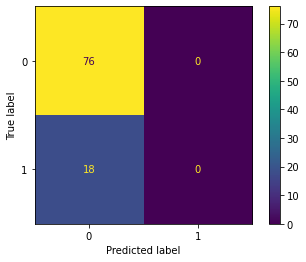

In [21]:
print(classification_report(y_test, lr_prediction))
print(confusion_matrix (y_test, lr_prediction))
ConfusionMatrixDisplay.from_predictions(y_test, lr_prediction);

## 2. Support vector classification

In [22]:
svc = SVC().fit(X_train, y_train)

In [23]:
parameters = {
    'C':[0.1,0.01, 0.001, 0.5,0.7,1,10,50, 100,150,170,180,190, 200,220, 250,300,1000],
    'gamma': ['scale','auto',0.1, 0.01,0.02, 0.05, 0.03, 0.07, 0.001, 0.009, 0.008],
}
svc_model = RandomizedSearchCV(svc, parameters, verbose=10, random_state=0).fit(X_train, y_train)
svc_model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=0.01, gamma=0.07.........................................
[CV 1/5; 1/10] END ..........C=0.01, gamma=0.07;, score=0.855 total time=   0.0s
[CV 2/5; 1/10] START C=0.01, gamma=0.07.........................................
[CV 2/5; 1/10] END ..........C=0.01, gamma=0.07;, score=0.867 total time=   0.0s
[CV 3/5; 1/10] START C=0.01, gamma=0.07.........................................
[CV 3/5; 1/10] END ..........C=0.01, gamma=0.07;, score=0.867 total time=   0.0s
[CV 4/5; 1/10] START C=0.01, gamma=0.07.........................................
[CV 4/5; 1/10] END ..........C=0.01, gamma=0.07;, score=0.867 total time=   0.0s
[CV 5/5; 1/10] START C=0.01, gamma=0.07.........................................
[CV 5/5; 1/10] END ..........C=0.01, gamma=0.07;, score=0.853 total time=   0.0s
[CV 1/5; 2/10] START C=250, gamma=0.01..........................................
[CV 1/5; 2/10] END ...........C=250, gamma=0.01;

{'gamma': 0.07, 'C': 0.01}

In [24]:
svc_model.best_estimator_

SVC(C=0.01, gamma=0.07)

## Support vector classification Analysis

In [79]:
thoracic_surgery_dict['svc'] = {'model':svc_model, 'hyperparameters':1}
svc_prediction = model_results(thoracic_surgery_dict['svc'])

0.8085106382978723
+------------------------+----------+
| Parameters / Metrics   |    Tuned |
+========================+==========+
| gamma                  | 0.07     |
+------------------------+----------+
| C                      | 0.01     |
+------------------------+----------+
| Accuracy               | 0.808511 |
+------------------------+----------+
| weighted_f1            | 0.722904 |
+------------------------+----------+
| macro_f1               | 0.447059 |
+------------------------+----------+


              precision    recall  f1-score   support

           0       0.81      1.00      0.89        76
           1       0.00      0.00      0.00        18

    accuracy                           0.81        94
   macro avg       0.40      0.50      0.45        94
weighted avg       0.65      0.81      0.72        94

[[76  0]
 [18  0]]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

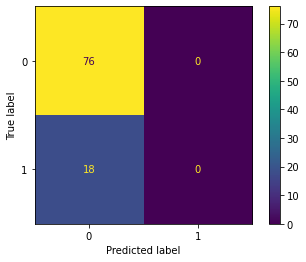

In [26]:
print(classification_report(y_test, svc_prediction))
print(confusion_matrix (y_test, svc_prediction))
ConfusionMatrixDisplay.from_predictions(y_test, svc_prediction);

## Decision tree

In [27]:
tree = DecisionTreeClassifier().fit(X_train, y_train)

In [28]:
parameters = {
    'max_depth': scipy.stats.uniform(1, 100),
    'min_samples_split': scipy.stats.uniform(0, 1) 
}
tree_model = RandomizedSearchCV(tree, parameters, verbose=1, n_iter=20, random_state=0).fit(X_train, y_train)
tree_model.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'max_depth': 8.103605819788694, 'min_samples_split': 0.08712929970154071}

## Decision tree Analysis

In [80]:
thoracic_surgery_dict['tree'] = {'model':tree_model, 'hyperparameters':1}
tree_prediction = model_results(thoracic_surgery_dict['tree'])

0.7978723404255319
+------------------------+-----------+
| Parameters / Metrics   |     Tuned |
+========================+===========+
| max_depth              | 8.10361   |
+------------------------+-----------+
| min_samples_split      | 0.0871293 |
+------------------------+-----------+
| Accuracy               | 0.797872  |
+------------------------+-----------+
| weighted_f1            | 0.717613  |
+------------------------+-----------+
| macro_f1               | 0.443787  |
+------------------------+-----------+


              precision    recall  f1-score   support

           0       0.81      0.99      0.89        76
           1       0.00      0.00      0.00        18

    accuracy                           0.80        94
   macro avg       0.40      0.49      0.44        94
weighted avg       0.65      0.80      0.72        94

[[75  1]
 [18  0]]


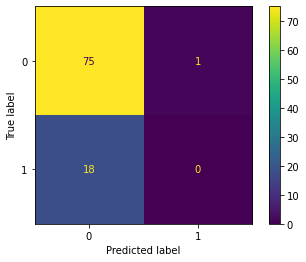

In [30]:
print(classification_report(y_test, tree_prediction))
print(confusion_matrix (y_test, tree_prediction))
ConfusionMatrixDisplay.from_predictions(y_test, tree_prediction);

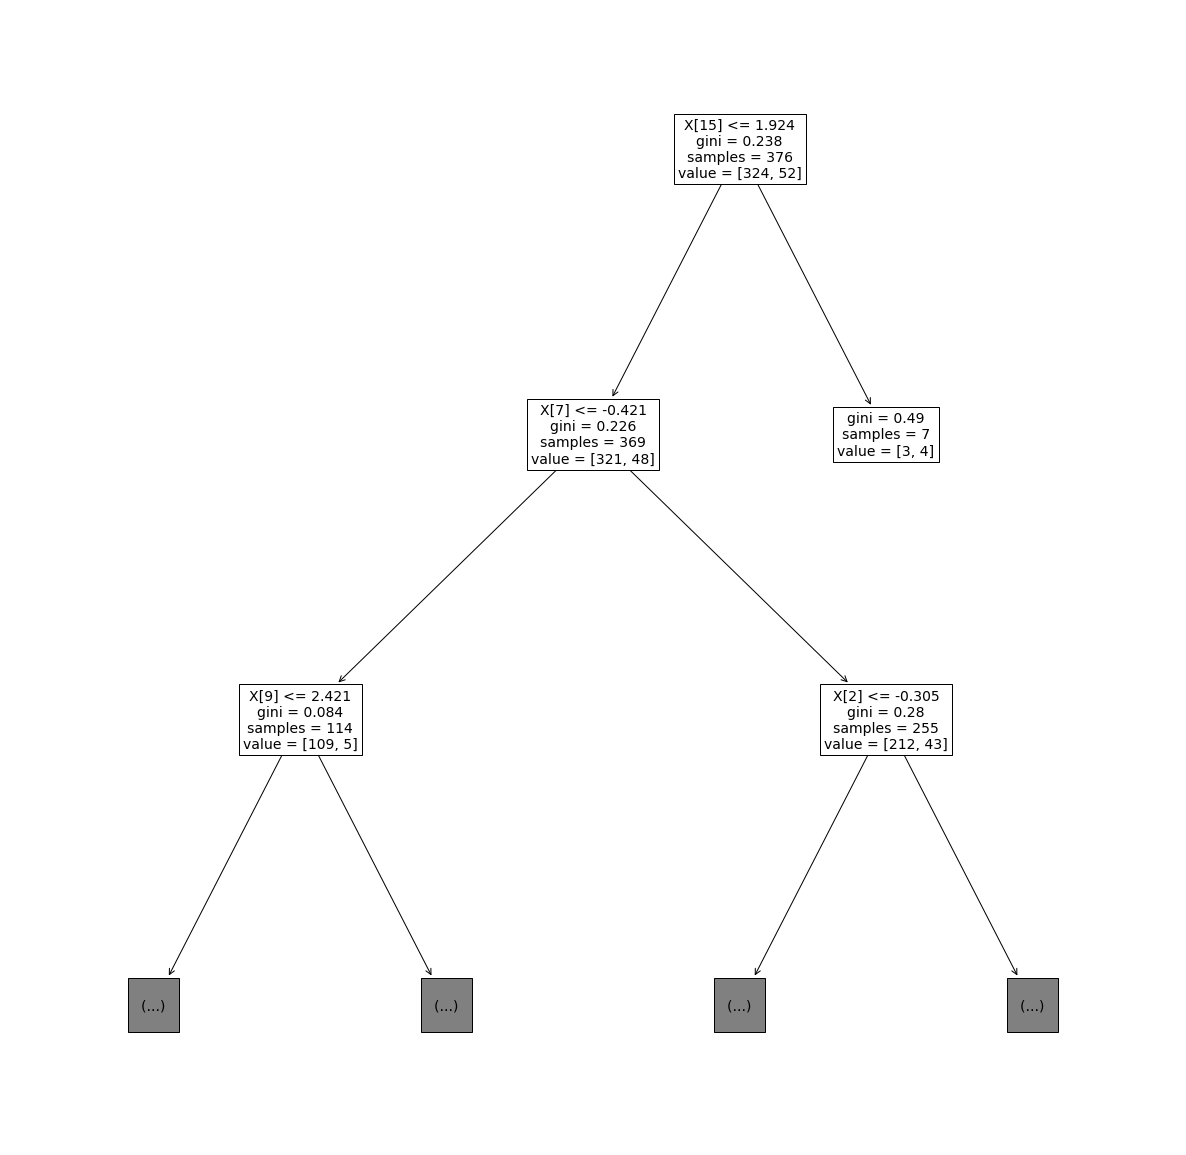

In [31]:
plt.figure(figsize=(21,21))
plot_tree(tree_model.best_estimator_, max_depth = 2, fontsize=14);

## Random Forest

In [71]:
forest = RandomForestClassifier(class_weight='balanced')
forest = forest.fit(X_train, y_train)

In [72]:
parameters = {
    'n_estimators': range(100,150),
    'max_depth': scipy.stats.uniform(1, 100),
}
forest_model = RandomizedSearchCV(forest, parameters, verbose=1, n_iter=20, random_state=0).fit(X_train, y_train)
forest_model.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'max_depth': 85.72517387841253, 'n_estimators': 119}

In [81]:
thoracic_surgery_dict['random_forest_r'] = {'model':forest_model, 'hyperparameters':1}
forest_prediction = model_results(thoracic_surgery_dict['random_forest_r'])

0.7872340425531915
+------------------------+------------+
| Parameters / Metrics   |      Tuned |
+========================+============+
| max_depth              |  85.7252   |
+------------------------+------------+
| n_estimators           | 119        |
+------------------------+------------+
| Accuracy               |   0.787234 |
+------------------------+------------+
| weighted_f1            |   0.712259 |
+------------------------+------------+
| macro_f1               |   0.440476 |
+------------------------+------------+


              precision    recall  f1-score   support

           0       0.80      0.97      0.88        76
           1       0.00      0.00      0.00        18

    accuracy                           0.79        94
   macro avg       0.40      0.49      0.44        94
weighted avg       0.65      0.79      0.71        94

[[74  2]
 [18  0]]


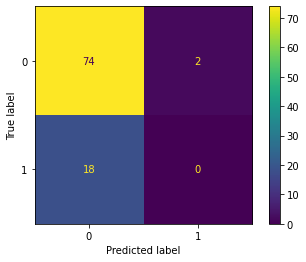

In [35]:
print(classification_report(y_test, forest_prediction))
print(confusion_matrix (y_test, forest_prediction))
ConfusionMatrixDisplay.from_predictions(y_test, forest_prediction);

## 5. K-nearest neighbours


Fitting and hyperparameter search

In [36]:
from sklearn import neighbors
import sklearn
import scipy

knn = sklearn.neighbors.KNeighborsClassifier(n_jobs=-1)

In [37]:
param_distribution = {'n_neighbors': range(1, 150), 'weights':['uniform', 'distance'], 'leaf_size': scipy.stats.uniform(1, 50)}
knn_randomized = sklearn.model_selection.RandomizedSearchCV(knn, param_distribution, verbose=1, random_state=0, cv=3, n_iter=25).fit(X_train, y_train)

print('best Hyperparameters = ' + str(knn_randomized.best_params_))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
best Hyperparameters = {'leaf_size': 28.440675196366236, 'n_neighbors': 118, 'weights': 'uniform'}


In [82]:
thoracic_surgery_dict["knn"] = {"model":knn_randomized, "hyperparameters":1}
knn_prediction = model_results(thoracic_surgery_dict['knn'])

0.8085106382978723
+------------------------+---------------------+
| Parameters / Metrics   | Tuned               |
+========================+=====================+
| leaf_size              | 28.440675196366236  |
+------------------------+---------------------+
| n_neighbors            | 118                 |
+------------------------+---------------------+
| weights                | uniform             |
+------------------------+---------------------+
| Accuracy               | 0.8085106382978723  |
+------------------------+---------------------+
| weighted_f1            | 0.7229036295369211  |
+------------------------+---------------------+
| macro_f1               | 0.44705882352941173 |
+------------------------+---------------------+


              precision    recall  f1-score   support

           0       0.81      1.00      0.89        76
           1       0.00      0.00      0.00        18

    accuracy                           0.81        94
   macro avg       0.40      0.50      0.45        94
weighted avg       0.65      0.81      0.72        94

[[76  0]
 [18  0]]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

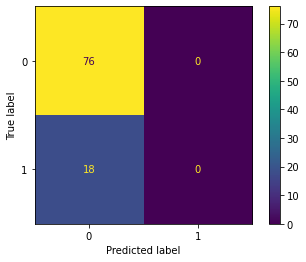

In [39]:
print(classification_report(y_test, knn_prediction))
print(confusion_matrix (y_test, knn_prediction))
ConfusionMatrixDisplay.from_predictions(y_test, knn_prediction);

## 6. AdaBoost Classification

Fitting and Hyperparameter search 

In [40]:
from sklearn.ensemble import AdaBoostClassifier

adaBoost = AdaBoostClassifier().fit(X_train,y_train)

In [41]:
param_distribution = {'n_estimators': range(1, 250), 'learning_rate': scipy.stats.uniform(.1, 5)}
adaBoost_randomized = sklearn.model_selection.RandomizedSearchCV(adaBoost, param_distribution, verbose=1, random_state=0, cv=5, n_iter=50).fit(X_train, y_train)

print('Best Hyperparameters = ' + str(adaBoost_randomized.best_params_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters = {'learning_rate': 4.918313802505146, 'n_estimators': 59}


In [83]:
thoracic_surgery_dict["adaboost"] = {"model":adaBoost_randomized, "hyperparameters":1}
adaboost_prediction = model_results(thoracic_surgery_dict['adaboost'])

0.7978723404255319
+------------------------+-----------+
| Parameters / Metrics   |     Tuned |
+========================+===========+
| learning_rate          |  4.91831  |
+------------------------+-----------+
| n_estimators           | 59        |
+------------------------+-----------+
| Accuracy               |  0.797872 |
+------------------------+-----------+
| weighted_f1            |  0.717613 |
+------------------------+-----------+
| macro_f1               |  0.443787 |
+------------------------+-----------+


              precision    recall  f1-score   support

           0       0.81      0.99      0.89        76
           1       0.00      0.00      0.00        18

    accuracy                           0.80        94
   macro avg       0.40      0.49      0.44        94
weighted avg       0.65      0.80      0.72        94

[[75  1]
 [18  0]]


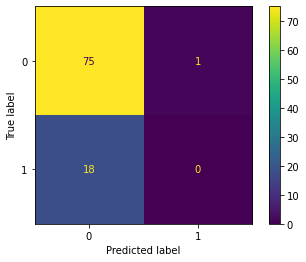

In [43]:
print(classification_report(y_test, adaboost_prediction))
print(confusion_matrix (y_test, adaboost_prediction))
ConfusionMatrixDisplay.from_predictions(y_test, adaboost_prediction);

## 7. Gaussian Naive Bayes classification

In [44]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB().fit(X_train, y_train)

In [45]:
# param_distribution = {'n_estimators': range(1, 150), 'learning_rate': scipy.stats.reciprocal(1, 5)}
# adaBoost_randomized = sklearn.model_selection.RandomizedSearchCV(adaBoost, param_distribution, verbose=1, random_state=0, cv=3, n_iter=250).fit(X_train, y_train)
# print('Best Hyperparameters = ' + str(knn_randomized.best_params_))

In [84]:
thoracic_surgery_dict["gnb"] = {"model":naive_bayes, "hyperparameters":0}
naive_bayes_prediction = model_results(thoracic_surgery_dict['gnb'])

0.20212765957446807
+------------------------+----------+
| Parameters / Metrics   |    Tuned |
+========================+==========+
| Accuracy               | 0.202128 |
+------------------------+----------+
| weighted_f1            | 0.100668 |
+------------------------+----------+
| macro_f1               | 0.18128  |
+------------------------+----------+


              precision    recall  f1-score   support

           0       0.67      0.03      0.05        76
           1       0.19      0.94      0.31        18

    accuracy                           0.20        94
   macro avg       0.43      0.49      0.18        94
weighted avg       0.57      0.20      0.10        94

[[ 2 74]
 [ 1 17]]


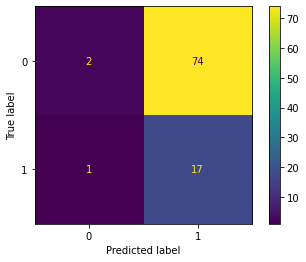

In [47]:
print(classification_report(y_test, naive_bayes_prediction))
print(confusion_matrix (y_test, naive_bayes_prediction))
ConfusionMatrixDisplay.from_predictions(y_test, naive_bayes_prediction);

## 8. Neural Network classification

In [48]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=900)

In [49]:
param_distribution = {'max_iter': range(1000, 1500),
                        'alpha': scipy.stats.reciprocal(0.00001, 0.1), 
                        'learning_rate':['constant', 'invscaling', 'adaptive']}

mlp_randomized = sklearn.model_selection.RandomizedSearchCV(mlp, param_distribution, verbose=1, random_state=0, cv=3, n_iter=25).fit(X_train, y_train)
print('Best Hyperparameters = ' + str(knn_randomized.best_params_))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Hyperparameters = {'leaf_size': 28.440675196366236, 'n_neighbors': 118, 'weights': 'uniform'}


In [85]:
thoracic_surgery_dict['nn'] = {"model":mlp_randomized, "hyperparameters":1}
nn_prediction = model_results(thoracic_surgery_dict['nn'])

0.7872340425531915
+------------------------+---------------------+
| Parameters / Metrics   | Tuned               |
+========================+=====================+
| alpha                  | 0.06007249475906195 |
+------------------------+---------------------+
| learning_rate          | adaptive            |
+------------------------+---------------------+
| max_iter               | 1244                |
+------------------------+---------------------+
| Accuracy               | 0.7872340425531915  |
+------------------------+---------------------+
| weighted_f1            | 0.7122593718338399  |
+------------------------+---------------------+
| macro_f1               | 0.44047619047619047 |
+------------------------+---------------------+


              precision    recall  f1-score   support

           0       0.80      0.97      0.88        76
           1       0.00      0.00      0.00        18

    accuracy                           0.79        94
   macro avg       0.40      0.49      0.44        94
weighted avg       0.65      0.79      0.71        94

[[74  2]
 [18  0]]


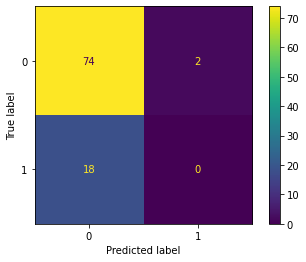

In [51]:
print(classification_report(y_test, nn_prediction))
print(confusion_matrix (y_test, nn_prediction))
ConfusionMatrixDisplay.from_predictions(y_test, nn_prediction);

+-----------------+----------+----------+----------+------------+----------+-----------+------------+---------------+
| model           |      acc |     w.f1 |    w.rec |   clas.rec |   tr.acc |   tr.w.f1 |   tr.w.rec |   tr.clas.rec |
+=================+==========+==========+==========+============+==========+===========+============+===============+
| nn              | 0.787234 | 0.712259 | 0.787234 |   0        | 0.965426 |  0.963669 |   0.965426 |     0.769231  |
+-----------------+----------+----------+----------+------------+----------+-----------+------------+---------------+
| random_forest_r | 0.787234 | 0.712259 | 0.787234 |   0        | 0.986702 |  0.986755 |   0.986702 |     0.961538  |
+-----------------+----------+----------+----------+------------+----------+-----------+------------+---------------+
| tree            | 0.797872 | 0.717613 | 0.797872 |   0        | 0.880319 |  0.850505 |   0.880319 |     0.211538  |
+-----------------+----------+----------+----------+----

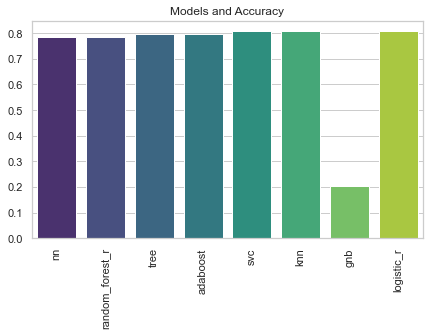

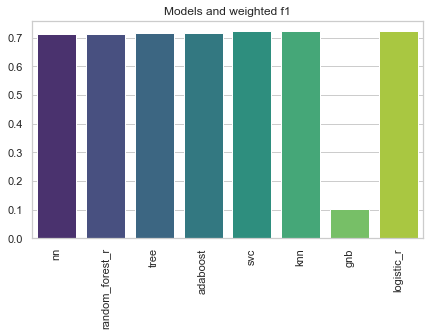

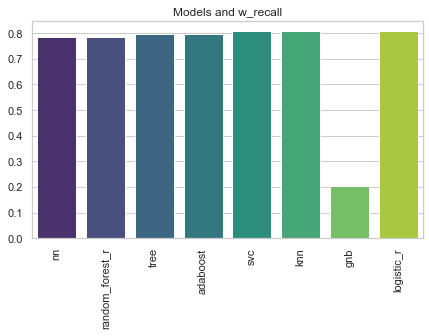

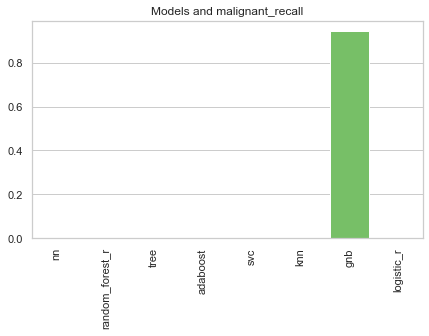

In [109]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,make_scorer,ConfusionMatrixDisplay,recall_score ,classification_report,accuracy_score,f1_score


def cross_checking_model_results(dictionary):
    table = [["model", "acc", "w.f1", 'w.rec', 'clas.rec',
              'tr.acc','tr.w.f1', 'tr.w.rec', 'tr.clas.rec']]
    x_models = []
    y_accuracy = []
    y_wf1 = []
    w_recall = []
    m_recall = []
    
    trny_accuracy = []
    trny_wf1 = []
    trnw_recall = []
    trnm_recall = []

    for model_key in MODELS:
        model = dictionary[model_key]['model']
        
        prediction = model.predict(X_test)
        accuracy = accuracy_score(y_test, prediction)
        weighted_f1 = f1_score(y_test, prediction, average='weighted')
        W_recall = recall_score(y_test, prediction,average='weighted')
        malignant_recall = recall_score(y_test, prediction,pos_label=1,average='binary')
        
        prediction_trn = model.predict(X_train)
        accuracy_trn = accuracy_score(y_train, prediction_trn)
        weighted_f1_trn = f1_score(y_train, prediction_trn, average='weighted')
        W_recall_trn = recall_score(y_train, prediction_trn,average='weighted')
        malignant_recall_trn = recall_score(y_train, prediction_trn,pos_label=1,average='binary')
        table.append([model_key, accuracy, weighted_f1, W_recall,malignant_recall,
                     accuracy_trn, weighted_f1_trn, W_recall_trn,malignant_recall_trn])
        
        x_models.append(model_key)
        y_accuracy.append(accuracy)
        y_wf1.append(weighted_f1)
        w_recall.append(W_recall)
        m_recall.append(malignant_recall)
        
        trny_accuracy.append(accuracy_trn)
        trny_wf1.append(weighted_f1_trn)
        trnw_recall.append(W_recall_trn)
        trnm_recall.append(malignant_recall_trn)
    print(tabulate(table, headers='firstrow', tablefmt='grid'))
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(7,4))
    ax1 = sns.barplot(x=x_models, y=y_accuracy, palette="viridis")
    ax1.set_title('Models and Accuracy')
    ax1.set_xticklabels(labels=x_models, rotation=90)
    plt.figure(figsize=(7,4))
    ax2 = sns.barplot(x=x_models, y=y_wf1, palette="viridis")
    ax2.set_title('Models and weighted f1')
    ax2.set_xticklabels(labels=x_models, rotation=90)
    
    plt.figure(figsize=(7,4))
    ax2 = sns.barplot(x=x_models, y=w_recall, palette="viridis")
    ax2.set_title('Models and w_recall')
    ax2.set_xticklabels(labels=x_models, rotation=90)
    plt.figure(figsize=(7,4))
    ax2 = sns.barplot(x=x_models, y=m_recall, palette="viridis")
    ax2.set_title('Models and malignant_recall')
    ax2.set_xticklabels(labels=x_models, rotation=90)


cross_checking_model_results(thoracic_surgery_dict)

In [ ]:
import pickle
with open('base_classification_dict.dictionary', 'rb') as config_dictionary_file:
    base_classification_dict = pickle.load(config_dictionary_file)
    
base_classification_dict['thoracic_surgery_dict']= thoracic_surgery_dict

with open('base_classification_dict.dictionary', 'wb') as config_dictionary_file:
    pickle.dump(base_classification_dict, config_dictionary_file)